## How can I tell the difference between a car and a chair?
So I can get to work on time.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Just import everything
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/matt/.conda/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = "data/chairscars/"  #custom imageset grabbed from Google Images
sz = 224

In [5]:
#make sure images are in their standard folders
os.listdir(PATH)

['tmp', 'models', 'train', 'valid', 'sample']

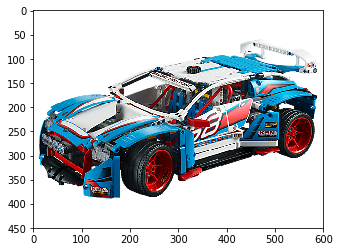

In [6]:
#This is a car
files = os.listdir(f'{PATH}valid/cars')[:5]

img = plt.imread(f'{PATH}valid/cars/{files[0]}')
plt.imshow(img);

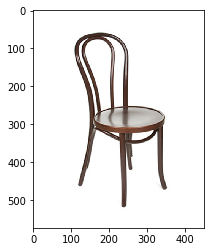

In [7]:
#This is a chair
files = os.listdir(f'{PATH}valid/chairs')[:5]

img = plt.imread(f'{PATH}valid/chairs/{files[0]}')
plt.imshow(img);

In [8]:
# Uncomment the below if you need to reset your precomputed activations
#shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [24]:
#Train this thing
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy        
    0      0.79501    0.237391   0.962963  
    1      0.481203   0.067853   0.994709        
    2      0.331409   0.025759   0.994709        



[array([0.02576]), 0.9947090010163645]

In [25]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(189, 2)

In [26]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(chair)

In [27]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [28]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [29]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


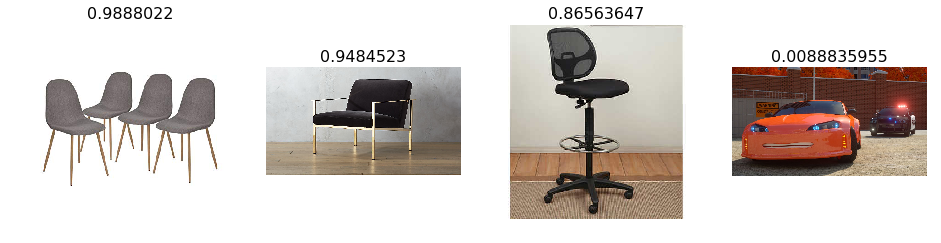

In [30]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [31]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct chairs


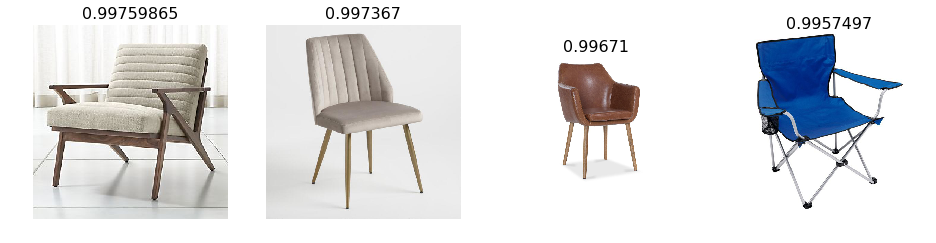

In [32]:
plot_val_with_title(most_by_correct(1, True), "Most correct chairs")

Most correct cars


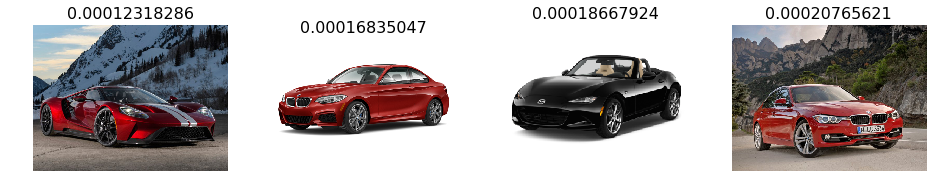

In [33]:
plot_val_with_title(most_by_correct(0, True), "Most correct cars")

Most incorrect chairs


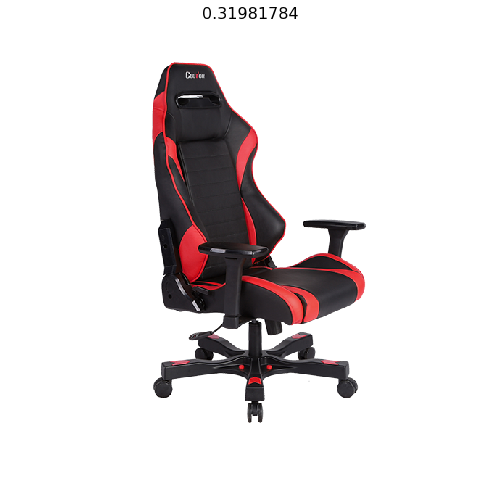

In [34]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect chairs")

In [35]:
plot_val_with_title(most_by_correct(0,False), "Most incorrect cars")

Most incorrect cars
Not Found.


Most uncertain predictions


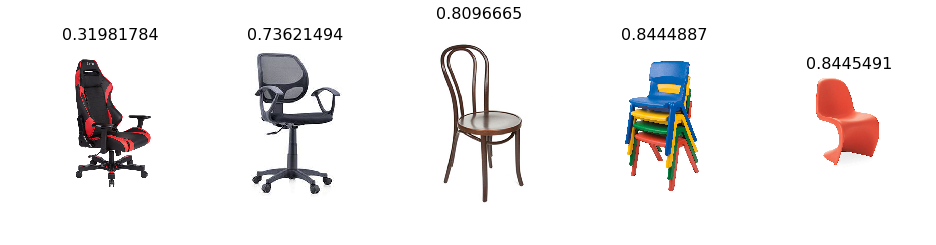

In [41]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:5]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Summary
After getting the image sets in the structure needed, this was pretty straightforward.
Chairs are easier to get wrong than cars, especially if they have racing stripes.

## COMMENTS